In [44]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from function import *


In [45]:
DATA_PATH = os.path.join('MP_DATA')

In [46]:


#subsequent actions
actions = np.array(['Rock', 'Ok', 'Like', 'Dislike', 'Victory', 'Namaste','Hug', 'PointingDown', 'PointingUp', 'PointingLeft', 'PointingRight', 'Call', 'Love', 'Stop', 'GoodLuck', 'Mute', 'Power', 'IfeelYOU', 'Whatever', 'Small'])


# Thirty videos worth of data
no_sequences = 30
# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

In [43]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [26]:
cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_styled_landmarks(image, results) 
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'CAPTURE', (150,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collect Sign of {} with frame no.  {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(300)
                else: 
                    cv2.putText(image, 'Collect Sign of {} with frame no. {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break                  
    
    cap.release()
    cv2.destroyAllWindows()

In [47]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Rock': 0,
 'Ok': 1,
 'Like': 2,
 'Dislike': 3,
 'Victory': 4,
 'Namaste': 5,
 'Hug': 6,
 'PointingDown': 7,
 'PointingUp': 8,
 'PointingLeft': 9,
 'PointingRight': 10,
 'Call': 11,
 'Love': 12,
 'Stop': 13,
 'GoodLuck': 14,
 'Mute': 15,
 'Power': 16,
 'IfeelYOU': 17,
 'Whatever': 18,
 'Small': 19}

In [48]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [49]:
np.array(sequences).shape

(600, 30, 126)

In [50]:
np.array(labels).shape

(600,)

In [51]:
X = np.array(sequences)
X.shape

(600, 30, 126)

In [52]:
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
y_test.shape

(30, 20)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [54]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten

model = Sequential()

# Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, 126)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# LSTM Layers
model.add(LSTM(128, return_sequences=True, activation='tanh', dropout=0.2))
model.add(LSTM(128, return_sequences=True, activation='tanh', dropout=0.2))
model.add(LSTM(64, return_sequences=False, activation='tanh', dropout=0.2))

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\SRINIVASA RAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [56]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])
model.summary()
# Train the model and capture history

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - categorical_accuracy: 0.0664 - loss: 2.9733
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.1824 - loss: 2.7398
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.2255 - loss: 2.4392
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.2775 - loss: 2.1980
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.2874 - loss: 1.9888
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.3640 - loss: 1.8040
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.3253 - loss: 1.8346
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.4103 - loss: 1.6432
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.4175 - loss: 1.6171
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.4667 - loss: 1.5024
Epoch 11/200
18/18

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 28, 64)         │        24,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 14, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 14, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 966,334 (3.69 MB)

 Trainable params: 322,068 (1.23 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 644,138 (2.46 MB)

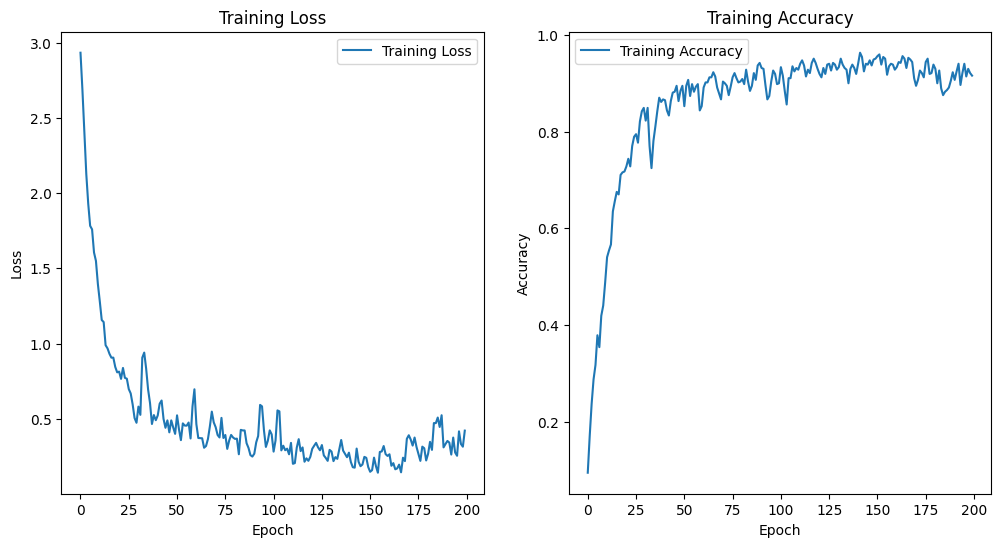

In [57]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
model.save('handgesture20.h5')


In [59]:
import tensorflow as tf

model = tf.keras.models.load_model('handgesture20.h5')



In [60]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


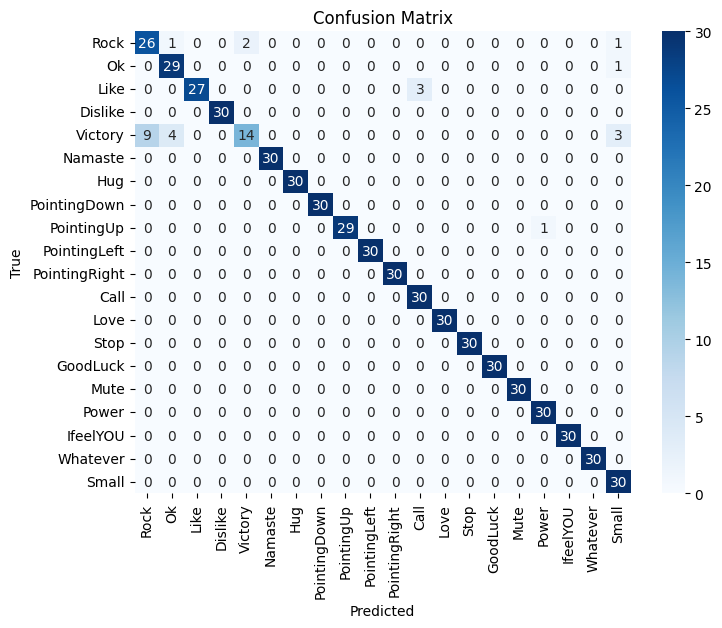

In [61]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Convert to numpy arrays
X_test = np.array(sequences)
y_test = np.array(labels)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [62]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Compute F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Compute precision
precision = precision_score(y_test, y_pred_classes, average='weighted')

# Compute recall
recall = recall_score(y_test, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.9583333333333334
F1 Score: 0.955221467675955
Precision: 0.9602387010522684
Recall: 0.9583333333333334
